In [1]:
# default_exp data.load_pd

In [2]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
# export
from fastseq.core import *
from fastseq.data.external import *
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *

In [4]:
# hide
from nbdev.showdoc import *

# Data Load Dataframe


> Using the fastai2 `Datasets` to make an time series dataset.

A multivaraite time-series dataloader. 

TODO reduce mem: https://forums.fast.ai/t/how-to-handle-dataframes-too-large-to-fit-in-memory/39208/19

In [5]:
# export
import numpy as np
import pandas as pd

In [6]:
# export
class TSMulti(MultiTuple):pass

## Transform catagorical data

In [7]:
# export
class TensorCatI(TensorBase):pass

class CatTfm(Transform):
    def __init__(self, df, cat_cols:[]): # maybe change to proccs
        self.vocab,self.o2i = {},{}
        for i, col in enumerate(L(cat_cols)):
            self.vocab[i], self.o2i[i] = uniqueify(list(df[col]), sort=True, bidir=True)
            
    def encodes(self, o:TensorCat):
        r = []
        for i in self.o2i:
            r.append(self.o2i[i][o.o[i]])            
        return TensorCatI(r, label = o._meta['label'])
    
    def decodes(self, o:TensorCatI): 
        r = []
        for i_cat in self.vocab:
            r.append(self.vocab[i_cat][o[i_cat]])
        return TensorCat(r, label = o._meta.get('label',None))
    
    

In [8]:
df = pd.DataFrame({'a':[i for i in 'aabb']})
tmf = CatTfm(df, ['a'])
o_tmf = tmf(TensorCat(['a']))
test_eq(tmf.decode(o_tmf),TensorCat(['a']))

In [9]:
df = pd.DataFrame({'a':[i for i in 'aabb'], 'a_2':[i for i in 'bccb'],})
tmf = CatTfm(df, ['a','a_2'])
o_tmf = tmf(TensorCat(['a','b']))
test_eq(tmf.decode(o_tmf),TensorCat(['a','b']))

In [10]:
# export
class TSMulti_(Tuple):pass

class CatMultiTfm(ItemTransform):
    @delegates(CatTfm.__init__)
    def __init__(self, *args, **kwargs): # maybe change to proccs
        self.f = CatTfm(*args, **kwargs)
        
    def encodes(self, o:TSMulti):
        return TSMulti_(self.f(a) for a in o)
    
    def decodes(self, o:TSMulti_): 
        return TSMulti(self.f.decode(a) for a in o)
    

In [11]:
df = pd.DataFrame({'a':[i for i in 'aabb']})
tmf = CatMultiTfm(df,'a')
print(tmf)
o = TSMulti(TensorBase([1]), TensorCat('a'))
o_tmf = tmf(o)
test_eq(o_tmf,(TensorBase([1]), TensorCatI([0])) )
o_b =tmf.decode(o_tmf)
test_eq(o_b, o)
test_eq(type(o_b), type(TSMulti(1)))

CatMultiTfm: True (TSMulti,object) -> encodes (TSMulti_,object) -> decodes


# Dataloader

In [12]:
# export
def array2series(o):
    return pd.Series(o.flatten())
def arrays2series(s:pd.Series):
    return pd.Series([array2series(o) for o in s])

In [13]:
df = pd.DataFrame(data={'x':  [np.arange(10.),
                               np.arange(12.)],
                       'ts_0':[np.ones(10)[None,:],
                               np.ones(12)[None,:]],
                       })
df['x'] = arrays2series(df['x'])
df['ts_0'] = arrays2series(df['ts_0'])
test_eq(type(df['ts_0']), pd.Series)
test_eq(type(df['x']), pd.Series)

In [14]:
# hide
df = pd.DataFrame(data={'x':  [np.arange(10.)]*100,
                       'ts_0':[np.ones(10)[None,:]]*100,
                       })
df['x'] = arrays2series(df['x'])
df['ts_0'] = arrays2series(df['ts_0'])
test_eq(type(df['ts_0']), pd.Series)
test_eq(type(df['x']), pd.Series)

In [48]:
# export
@delegates()
class DfDataLoader(TfmdDL):
    def __init__(self, dataset:pd.DataFrame, y_name:str, horizon:int, lookback=72, step=1, min_seq_len=None, max_std= None, norm=True, **kwargs):
        store_attr(self,'horizon,lookback,step,max_std,norm,y_name')
        self.min_seq_len = ifnone(min_seq_len, lookback)
        self.dataset = dataset
        self.con_names, self.cat_names, self.ts_names = L(), L(), L()
        for col in dataset.columns:
            t = type(dataset[col].iloc[0])
            if t is pd.core.series.Series:
                self.ts_names.append(col)
            elif t is np.ndarray:
                o = arrays2series(dataset[col])
                self.dataset[col] = o
                self.ts_names.append(col)
            elif isinstance(dataset[col].iloc[0], str):
                self.cat_names.append(col)
            elif isinstance(dataset[col].iloc[0], float) or isinstance(dataset[col].iloc[0], int) or t is np.int64:
                self.con_names.append(col)
            else:
                raise Exception(t) 
        assert y_name in self.ts_names, {k:v for k,v in zip(['cat','con','seq'], [self.cat_names,self.con_names,self.ts_names])}
        self.ts_names.remove(y_name)
        n = self.make_ids()
        kwargs.update({'after_item': CatMultiTfm(dataset, self.cat_names)})
        super().__init__(dataset=self.dataset, **kwargs)
        self.n = n
        self.skipped= []      

    @delegates(TfmdDL.new)
    def new(self, dataset=None, cls=None, **kwargs):
        for k,v in {k:getattr(self,k) for k in ['horizon', 'lookback', 'step']}.items():
            if k not in kwargs:
                kwargs[k] = v
        res = super().new(dataset = dataset,cls= cls, y_name= self.y_name, **kwargs)
        res.make_ids()
        return res
    
    def check_std(self, r):  
        if self.max_std is not None:
            if (r[-1]/(r[0].std()+1e-7)).std() > self.max_std:
                if idx not in self.skipped:
                    self.skipped.append(idx)
                raise SkipItemException()
        
    def make_ids(self):
        """Make ids if the sequence is shorter than `min_seq_len`, it will drop that sequence."""
        # Slice each time series into examples, assigning IDs to each
        last_id = 0
        n_dropped = 0
        n_needs_padding = 0
        self._ids = {}
        for i, ts in self.dataset.iterrows(): 
            assert same_size_ts(ts, self.ts_names), f"row {i} are not all the time series the same length"
            num_examples = (ts[self.y_name].shape[-1] - self.lookback - self.horizon + self.step) // self.step
            # Time series shorter than the forecast horizon need to be dropped.
            if ts[self.y_name].shape[-1] < self.min_seq_len:
                n_dropped += 1
                continue
            # For short time series zero pad the input
            if ts[self.y_name].shape[-1] < self.lookback + self.horizon:
                n_needs_padding += 1
                num_examples = 1
            for j in range(num_examples):
                self._ids[last_id + j] = (i, j * self.step)
            last_id += num_examples

        # Inform user about time series that were too short
        if n_dropped > 0:
            print("Dropped {}/{} time series due to length.".format(
                    n_dropped, len(self.dataset)))

        # Inform user about time series that were short
        if n_needs_padding > 0:
            print("Need to pad {}/{} time series due to length.".format(
                    n_needs_padding, len(self.dataset)))
        # Store the number of training examples
        return int(self._ids.__len__() )
    
        def shuffle_fn(self, idxs):
#         self.dataset.shuffle()        
            return idxs

    def get_id(self, idx):
        ts_id, lookback_id = self._ids[idx]
        row = self.dataset.iloc[ts_id, :]
        x = get_part_of_ts(row[self.y_name].values, lookback_id, self.lookback)        
        y = get_part_of_ts(row[self.y_name].values, lookback_id, self.lookback + self.horizon)
        if len(self.ts_names):
            tsx = np.concatenate([o[None,:] for o in row[self.ts_names].to_numpy()])
            tsx = get_part_of_ts(tsx, lookback_id, self.lookback + self.horizon)
        else:
            tsx = tensor(row[self.ts_names].to_numpy().astype(float))
        r = [TensorSeqs(x, label=[self.y_name + '_x'], m=['g']), 
             TensorSeqs(tsx, label=self.ts_names)]
        r.append(TensorCat(list(row[self.cat_names]), label=self.cat_names))
        # TODO make cat its own type
        r.append(TensorCon(row[self.con_names].to_numpy().astype(float),label=self.con_names))            
        # TODO make y its own type
        r.append(TensorSeqs(y, label=[self.y_name + '_y'], m=['g']))
        return tuple(r)

    def create_item(self, idx):
        if idx>=self.n:
            raise IndexError
        r  = self.get_id(idx)
        self.check_std(r)  
        return TSMulti(r)    

The data will be stored in pandas DataFrames. This can be use for time series by nesting series into a cell. An example is shown below: 

In [49]:
def get_df():
    return pd.DataFrame(data={'x':[np.arange(10.),
                           np.arange(12.)],
                   'ts_0':[np.ones(10)[None,:],
                           np.ones(12)[None,:]],
                   'ts_1':[pd.Series(np.arange(1,11)+np.random.randn(10)),
                           pd.Series(np.arange(1,13)+np.random.randn(12))],
                   'var_0':[0.,1.],
                   'con_0':['a','b']
                       })
df = get_df()
df

,x,ts_0,ts_1,var_0,con_0
0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]",0 1.055906 1 2.241100 2 2.781684 3 4.149537 4 5.567199 5 6.418103 6 7.621117 7 5.986438 8 7.454972 9 10.762808 dtype: float64,0.0,a
1,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]",0 0.242220 1 2.165197 2 2.316616 3 3.576602 4 6.674486 5 6.562100 6 5.570824 7 7.021683 8 11.008279 9 10.408829 10 11.951690 11 11.839840 dtype: float64,1.0,b


In [50]:
horizon,lookback = 2,9
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback)

for o in dl:
    test_eq(type(o), TSMulti_)
    test_eq(len(o),5)
    dct = {k:v for k,v in zip(['x','tsx','cat','con','y'], o)}
    test_eq(type(o), TSMulti_)
    test_eq(dct['x'].shape[1:], (1,lookback))
    test_eq(dct['y'].shape[1:], (1,lookback+horizon))
    test_eq(dct['tsx'].shape[1:], (2,lookback+horizon))
    break

Need to pad 1/2 time series due to length.


In [51]:
# hide
# without cat or con
horizon,lookback = 3,5
df = get_df()
dl = DfDataLoader(df.loc[:,['x','ts_0']], 'x', horizon = horizon, lookback = lookback)


for o in dl:
    test_eq(type(o), TSMulti_)
    test_eq(len(o),5)
    dct = {k:v for k,v in zip(['x','tsx','cat','con','y'], o)}
    test_eq(type(o), TSMulti_)
    test_eq(dct['x'].shape[1:], (1,lookback))
    test_eq(dct['y'].shape[1:], (1,lookback+horizon))
    test_eq(dct['cat'].shape[1:], ([0]))
    test_eq(dct['con'].shape[1:], ([0]))
    test_eq(dct['tsx'].shape[1:], (1,lookback+horizon))
    
test_eq(first(dl), dl.one_batch())

In [52]:
# hide
# without tsx
horizon,lookback = 3,5
df = get_df()
dl = DfDataLoader(df.loc[:, ['x','var_0','con_0']], 'x', horizon = horizon, lookback = lookback, num_workers = 0)


for o in dl:
    test_eq(type(o), TSMulti_)
    test_eq(len(o),5)
    dct = {k:v for k,v in zip(['x','tsx','cat','con','y'], o)}
    test_eq(type(o), TSMulti_)
    test_eq(dct['x'].shape[1:], (1,lookback))
    test_eq(dct['y'].shape[1:], (1,lookback+horizon))
    test_eq(dct['cat'].shape[1:], ([1]))
    test_eq(dct['con'].shape[1:], ([1]))
    test_eq(dct['tsx'].shape[1:], ([0]))
    
test_eq(first(dl), dl.one_batch())

In [53]:
# hide
# test self.new
dl.new()

# Showing

In [54]:
# export

def _show_batch_class(self, b=None, max_n=9, ctxs=None, show=True, **kwargs):
    if b is None: b = self.one_batch()
    x, y, its = self._pre_show_batch(b, max_n=max_n)
    x = self.after_item.decode(TSMulti_(x))
    if not show: return x, y, its
    show_batch(x,y,its, ctxs=ctxs, max_n=max_n, **kwargs)

DfDataLoader.show_batch = _show_batch_class

In [55]:
# export
from fastai2.vision.data import get_grid
@typedispatch
def show_batch(x:TSMulti, y:TensorSeqs, its, *args, ctxs=None, max_n=10, rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), add_vert=1, figsize=figsize, **kwargs)
    for i, ctx in enumerate(ctxs):  
        o = TSMulti([type(o)(o,**o._meta) for o in its[i] if o.shape[-1] > 0])
        ctx = o.show(ctx=ctx)
    return ctxs

@typedispatch
def show_batch(x:TSMulti, y:None, its, *args, ctxs=None, max_n=10, rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), add_vert=1, figsize=figsize, **kwargs)
    for i, ctx in enumerate(ctxs):  
        o = TSMulti([type(o)(o[i],**o[i]._meta) for o in x if o.shape[-1] > 0])
        ctx = o.show(ctx=ctx)
    return ctxs

In [56]:
show_batch

(TSMulti,NoneType) -> show_batch
(TSMulti,TensorSeqs) -> show_batch
(TensorImage,TensorImage) -> show_batch
(TensorImage,object) -> show_batch
(Tabular,object) -> show_batch
(object,object) -> show_batch

Need to pad 1/2 time series due to length.


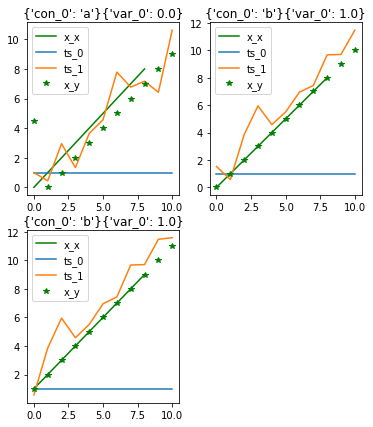

In [57]:
horizon,lookback = 2,9
df = get_df()
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback)
dl.show_batch()

Need to pad 1/2 time series due to length.


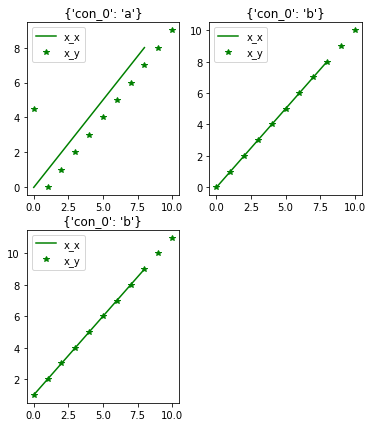

In [58]:
# hide
horizon,lookback = 2,9
df = get_df()
dl = DfDataLoader(df.loc[:,['x','con_0']], 'x', horizon = horizon, lookback = lookback)
dl.show_batch()

In [59]:
# export

# def _show_results_class(self, b, out, max_n=9, ctxs=None, show=True, **kwargs):
#     x,y,its = self.show_batch(b, max_n=max_n, show=False,)
#     x = self.after_item.decode(b)
#     b_out = b[:self.n_inp] + (tuple(out) if is_listy(out) else (out,))
#     x1,y1,outs = self.show_batch(b_out, max_n=max_n, show=False)
#     res = (x,x1,None,None) if its is None else (x, y, its, outs.itemgot(slice(self.n_inp,None)))
#     if not show: return res
#     show_results(*res, ctxs=ctxs, max_n=max_n, **kwargs)
    
# DfDataLoader.show_results = _show_results_class

In [60]:
#export
# from fastseq.data.load_pd import *

@typedispatch
def show_results(x:TSMulti, y, its, outs, ctxs=None, max_n=9,rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), add_vert=1, figsize=figsize, **kwargs)
    for i, ctx in enumerate(ctxs):  
        r = [type(o)(o,**o._meta) for o in its[i] if o.shape[-1] > 0] 
        r.append(type(its[i][-1])(outs[i][0], label=['pred_y'], m=['r']))
        o = TSMulti(r)        
        ctx = o.show(ctx=ctx) 


In [61]:
show_results

(TSMulti,object) -> show_results
(object,object) -> show_results

In [62]:
a = TensorSeqs([0], label = ['a'])
a._meta

{'label': ['a']}

Need to pad 1/2 time series due to length.
(#4) [0,336.010986328125,308.464599609375,'00:00']
Need to pad 1/2 time series due to length.
Need to pad 1/2 time series due to length.


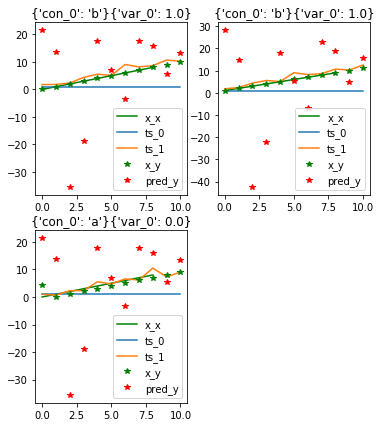

In [63]:
class RegModel(Module):
    def __init__(self, in_f, out_f): 
        self.a,self.b = nn.Parameter(torch.randn(in_f,in_f+out_f)),nn.Parameter(torch.randn(in_f+out_f))
    def forward(self, x, *args): return (torch.mm(x[:,0,:],self.a) + self.b)[:,None,:]
    
def synth_learner(lookback, horizon, cuda=False, lr=1e-3, data=None, **kwargs):
    return Learner(data, RegModel(lookback,horizon), lr=lr, loss_func=MSELossFlat(),
                   opt_func=partial(SGD, mom=0.9), **kwargs)
horizon,lookback = 2,9
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback)
learn = synth_learner(lookback, horizon, data=DataLoaders(dl, dl))

learn.fit(1)

learn.show_results(max_n=9)

Need to pad 1/2 time series due to length.
(#4) [0,302.3023681640625,277.4828186035156,'00:00']
Need to pad 1/2 time series due to length.
Need to pad 1/2 time series due to length.


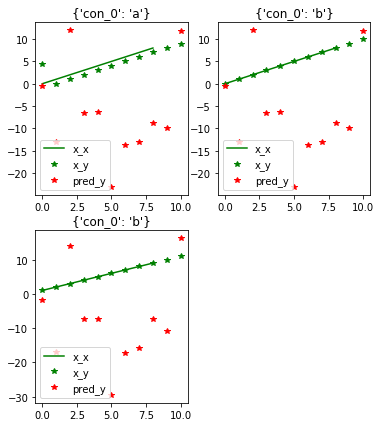

In [64]:
# hide
# wo tsx
class RegModel(Module):
    def __init__(self, in_f, out_f): 
        self.a,self.b = nn.Parameter(torch.randn(in_f,in_f+out_f)),nn.Parameter(torch.randn(in_f+out_f))
    def forward(self, x, *args): return (torch.mm(x[:,0,:],self.a) + self.b)[:,None,:]
    
def synth_learner(lookback, horizon, cuda=False, lr=1e-3, data=None, **kwargs):
    return Learner(data, RegModel(lookback,horizon), lr=lr, loss_func=MSELossFlat(),
                   opt_func=partial(SGD, mom=0.9), **kwargs)
horizon,lookback = 2,9
df = get_df()
dl = DfDataLoader(df.loc[:,['x','con_0']], 'x', horizon = horizon, lookback = lookback)
learn = synth_learner(lookback, horizon, data=DataLoaders(dl, dl))

learn.fit(1)

learn.show_results(max_n=9)

# Intergration Example

In [65]:
from fastseq.data.external import *

In [68]:
horizon,lookback = 5,10
df = dummy_data_generator_multi(32)
df['city'] = df['city']
df.head()

,x,weather,city,cont
0,"[[1.8276160610464545, 1.254985084462664, 0.9896985512174602, 0.7776651352289536, 0.5656554982578915, 0.8129791137492645, 0.7735503466350724, 1.0599236031396104, 0.9255117779013688, 0.6696299937471322, 0.49550484519863314, 0.08973982012221375, -0.40416914019960515, -0.9311899413131178, -1.0497779665049682, -1.0112257619500833, -0.9657919673040168, -0.15304516288064146, 0.29382577215281047, 0.8682592716975173, 1.1128675253106093, 0.9216229276040907, 0.2145075708234694, -0.49163509077153145, -1.3237595955829964, -2.156779500958198, -1.9832691393443025, -1.6000641553555544, -0.9089301246523649...","[[4.110456525204809, 4.01751614139884, 4.522351775615862, 5.357535176320556, 6.1870927274003416, 6.796168521404556, 6.9567681921586715, 6.415055228756403, 5.2277582832066845, 4.005083821695578, 3.5420655174537465, 4.076223610689981, 5.008990148451685, 5.487102860008891, 5.236328895288063, 4.740452358765627, 4.110456525204809, 4.01751614139884, 4.522351775615862, 5.357535176320556, 6.1870927274003416, 6.796168521404556, 6.9567681921586715, 6.415055228756403, 5.2277582832066845, 4.005083821695578, 3.5420655174537465, 4.076223610689981, 5.008990148451685, 5.487102860008891, 5.236328895288063,...",adam,0.925830
1,"[[0.8444456028506572, 0.6237834292975145, 0.7461884128869455, 0.5746150271689018, 0.5160035784983302, 0.30409238848446585, 0.6142159955251105, 1.2463069520636179, 1.5988896247046875, 1.7854288222012122, 1.6178567499364198, 1.191697134486774, 0.86559799526373, 1.0897523863349268, 0.48103998366070927, -0.2370901781057514, -0.22904535739112963, -0.45274953136600393, -0.8250333893438414, -0.8990273590587439, -1.4899909056623506, -1.7794666684086173, -1.6301605779418853, -1.448413435977313, -0.5731522535589416, -0.0939614976406212, -0.4911927854802042, -0.696408993854432, -1.0307066309045736, -...","[[8.423980310082591, 8.321278560919424, 9.042548579559256, 9.444737701050524, 8.373221206407191, 6.59594233806797, 6.156095488095502, 7.763992544897299, 9.689865342516807, 9.770808573925036, 8.012138180051721, 6.444734603633227, 6.525057753827433, 7.534194369120381, 7.91587903203363, 7.476415413327238, 8.423980310082591, 8.321278560919424, 9.042548579559256, 9.444737701050524, 8.373221206407191, 6.59594233806797, 6.156095488095502, 7.763992544897299, 9.689865342516807, 9.770808573925036, 8.012138180051721, 6.444734603633227, 6.525057753827433, 7.534194369120381, 7.91587903203363, 7.4764154...",adam,0.391803
2,"[[1.0684968718055043, 1.050932854233109, 1.0065341680590378, 1.0789164173502408, 1.182797684394413, 1.3252345582182967, 1.2565496665646418, 1.5302954027499314, 1.644302476543488, 1.3565366549192002, 0.7188331309510583, 0.3316010769799961, 0.21035112045614932, 0.08944728509793753, -0.0656737397148953, -0.25816691934835784, -0.22054088001855507, -0.25475964126993683, 0.026761062628285606, -0.10222629703477311, -0.3419274262194789, -0.755513027720607, -1.0591140997150181, -0.9956538824303146, -1.0911570403131046, -1.1281758661336523, -1.238424751337749, -1.2771335394008487, -1.126567053719909...","[[5.136047042346414, 4.988899077651614, 6.213038249606569, 7.368834229204506, 6.845023603252564, 5.101544002872019, 4.093258829321037, 4.660704492769722, 5.477798937705242, 4.991843323284673, 3.6562298052335844, 3.355298033828333, 4.807276589904107, 6.533139645083741, 6.823054009909519, 5.996256872137809, 5.136047042346414, 4.988899077651614, 6.213038249606569, 7.368834229204506, 6.845023603252564, 5.101544002872019, 4.093258829321037, 4.660704492769722, 5.477798937705242, 4.991843323284673, 3.6562298052335844, 3.355298033828333, 4.807276589904107, 6.533139645083741, 6.823054009909519, 5.9...",adam,0.957279
3,"[[-0.522049894382129, -0.7577469308200246, -0.738117692027903, -0.5276099561056325, 0.1924590776665597, 0.23222385718844948, 0.8362268369287655, 0.954937349281663, 0.8718233671332948, 0.34440632709509994, 0.11900468585760475, -0.6071661551230421, -0.8568503561880847, -1.0490801271488406, -0.9834480849004578, -1.007

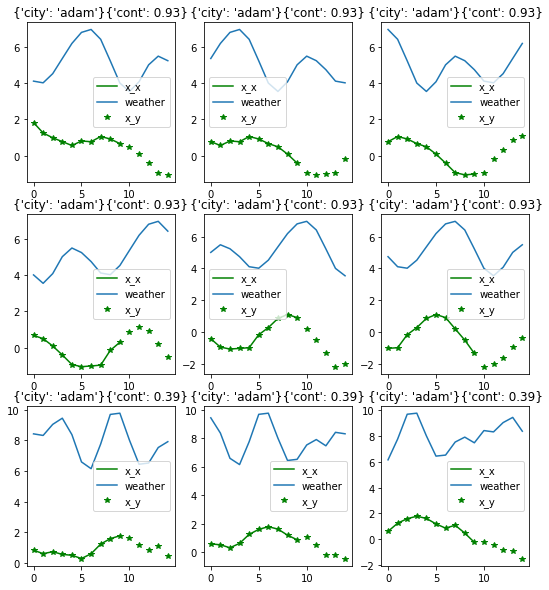

In [69]:
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback, step=3, bs=32)
dl.show_batch(max_n=9)

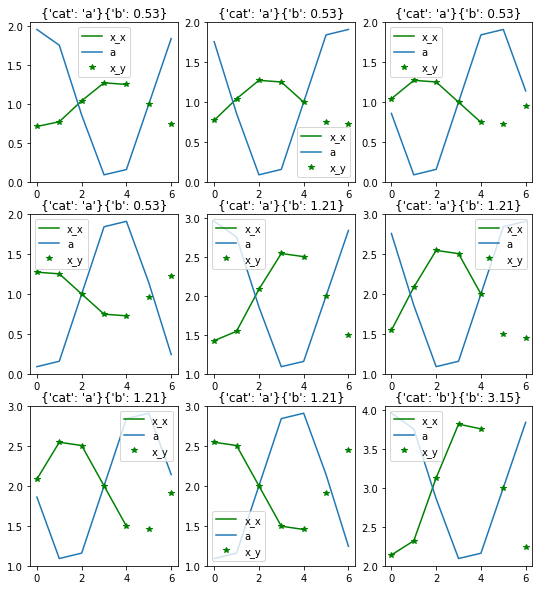

In [70]:
# hide
from fastseq.data.load import *
horizon,lookback = 2,5
t = np.arange(-5,5.)
a = np.sin(t)
df = pd.DataFrame({'x':[i + (i*.6)*a*-.5 for i in range(1,5)],
                   'a':[i+a for i in range(1,5)],
                   'b':[i+torch.randn(1).numpy()[0] for i in range(1,5)],
                   'cat':[i for i in 'aabb'],                  
                  })
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback, 
#                   after_batch = NormalizeTSMulti(),
                  num_workers = 1)
dl.show_batch()

# M5 Example

In [71]:
path = Path('../data/m5')
path.ls()

(#8) [Path('../data/m5/sales_train_validation.csv'),Path('../data/m5/M5-Competitors-Guide_Final-1.pdf'),Path('../data/m5/sample_submission.csv'),Path('../data/m5/Screenshot from 2020-03-04 13-24-55.png'),Path('../data/m5/calendar.csv'),Path('../data/m5/m5-forecasting-accuracy.zip'),Path('../data/m5/Screenshot from 2020-03-04 13-25-42.png'),Path('../data/m5/sell_prices.csv')]

In [72]:
df_sales = pd.read_csv(path / 'sales_train_validation.csv',).iloc[:100,:]
df_sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [73]:
def _to_series(df):
    r = []
    for i in range(df.shape[0]):
        r.append(pd.Series(df.iloc[i,6:].values.astype(float)))
    return r

def to_contained_series(df):    
    data={k:v for k,v in dict(df).items() if 'd_' not in k}
    data['sales'] = pd.Series(_to_series(df))
    df = pd.DataFrame(data=data)
    return df
df_sales_s = to_contained_series(df_sales)

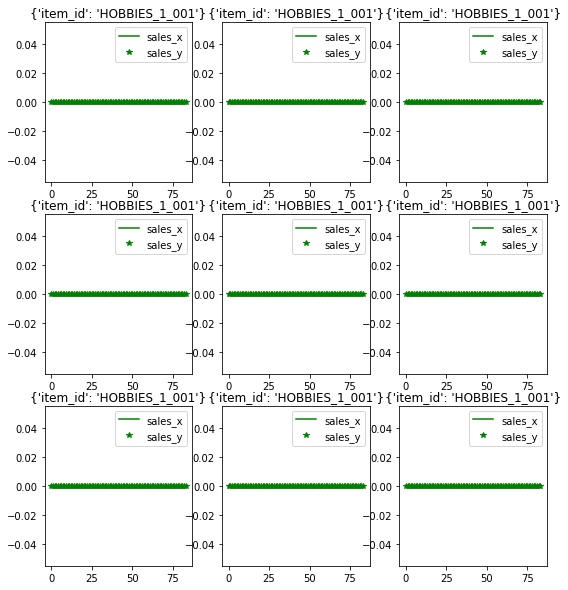

In [74]:
dl =  DfDataLoader(df_sales_s.loc[:,['sales','item_id']], 'sales', horizon = 28, lookback=28*2, step=7)
dl.show_batch(max_n=9)

In [ ]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 020_data.load_pd.ipynb.
Converted 02_data.load.ipynb.
Converted 030_data.core_pd.ipynb.
Converted 03_data.core.ipynb.
Converted 050_nbeats.models_multi.ipynb.
